# Seq2Seq

### 한글 --> 영어

par_corp.csv

# Data preprocess

In [41]:
import numpy as np
import re
import pandas as pd
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
# 파일 불러와서 약간의 전처리
files = open("./data/par_corp.csv", encoding='utf-8')

re_lines = []
for line in files:
    if line[0] == '[':
        continue
    re_line = re.sub('[#".?!\n]', '', line)
    re_lines.append(re_line)

kor = []
eng = []
count = 0
for line in re_lines:
    count = count + 1
    if count % 2 == 0:
        kor.append(line)
    else:
        eng.append(line)

d = {'kor':kor, 'eng':eng}
par_corp = pd.DataFrame(d)

print(par_corp)

kor                                        eng
0            명령은 아래와 같이 반포되었다                  The order went forth that
1         명령은 반드시 엄격히 준수해야 한다         The orders must be strictly obeyed
2       운명의 여신은 용사를 특별히 애호하신다                  fortune favors the brave 
3         운명에 그가 죽을 것이라고 정해졌다            Fate destined that he shall die
4      운명에 그는 목사가 될 것이라고 정해졌다         Fate had ordained him to die young
...                       ...                                        ...
47662              사자는 야생동물이다                  The lion is a wild animal
47663            사자는 황야로 도망갔다  The lion escaped and returned to the wild
47664   사자는 우리 안에서 천천히 왔다갔다한다       The lion paced the floor of its cage
47665   젖은 셔츠가 그의 몸에 착 달라붙어있다            The wet shirt clung to his body
47666      젖은 성냥은 그어도 켜지지 않는다                  Damp matches won't strike

[47667 rows x 2 columns]


In [43]:
# 토큰화 (스탑워드 제거) -> 단어 별로 나누기 위해서
# 정수 인코딩 -> 컴퓨터가 잘 알아들을수 있도록 단어로 된거를 숫자로 변형
# 패딩 -> embedding layer를 통과하려면 벡터의 길이가 같아야하기 때문에
encoder_input, decoder_input, decoder_output = [], [], []

# 왜 디코더는 인풋/아웃풋 둘 다 존재?
# '나는 개와 산책을 하고 있다' -> 인코더를 거치면서 셀/은닉 상태 리턴

# 위 문장의 셀 상태랑 은닉 상태 + <start> 가 인풋으로 들어가면

# 지금까지 쌓아진 셀/은닉 상태 값, 현재 단어 -> 다음 단어

#### <start>가 예측한 단어 = <start> 바로 다음 단어

# 훈련을 시키고나서 보면 (상태값이 없다면) <start> 뒤에는 굉장히 다양한 단어가 올 수 있음
# <start> 는 뒤에 어떤 단어든지 올 수 있는 단어의 역할
# 상태값을 함께 고려하도록 해주면, 모든 단어들 중에서 상태값에 연관되어있는 것만 높을 확률을 부여

# 단어의 예측을 바로 전 단어를 기준으로
# <end> 는 이제 더 이상 그만 예측하라는 뜻

# '<start> i am taking a walk with my dog' -> 추측을 하는데 사용되고 있음
# 'i am taking a walk with my dog <end>'

for stc in par_corp['kor']:
    encoder_input.append(stc.split())

# 스타트 뒤에 띄어쓰기 있습니다
# <start> 띄어쓰기를 한 이유는 split을 할 때, 띄어쓰기를 기준으로 split하기 때문
# 문장이 있으면 ['<start>', 'i', 'am', 'taking']
for stc in par_corp['eng']:
    decoder_input.append(("<start> "+stc).split())

# 엔드 앞에 띄어쓰기 있습니다
# <end>도 마찬가지
for stc in par_corp['eng']:
    decoder_output.append((stc+" <end>").split())

In [44]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['명령은', '아래와', '같이', '반포되었다'], ['명령은', '반드시', '엄격히', '준수해야', '한다'], ['운명의', '여신은', '용사를', '특별히', '애호하신다']]
[['<start>', 'The', 'order', 'went', 'forth', 'that'], ['<start>', 'The', 'orders', 'must', 'be', 'strictly', 'obeyed'], ['<start>', 'fortune', 'favors', 'the', 'brave']]
[['The', 'order', 'went', 'forth', 'that', '<end>'], ['The', 'orders', 'must', 'be', 'strictly', 'obeyed', '<end>'], ['fortune', 'favors', 'the', 'brave', '<end>']]


In [45]:
tokenizer_ko = Tokenizer()
tokenizer_ko.fit_on_texts(encoder_input)
encoder_input = tokenizer_ko.texts_to_sequences(encoder_input)

# 1~4999(패딩하기 전) -> 0~4999(패딩하고 난 뒤)
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(decoder_input)
tokenizer_en.fit_on_texts(decoder_output)
# 정수 인코딩할 때는 1부터 인덱스를 부여
decoder_input = tokenizer_en.texts_to_sequences(decoder_input)
decoder_output = tokenizer_en.texts_to_sequences(decoder_output)

In [46]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[10325, 1216, 312, 23138], [10325, 66, 8026, 6543, 12], [8027, 23139, 23140, 1162, 23141]]
[[2, 1, 175, 97, 670, 19], [2, 1, 761, 78, 31, 2133, 11983], [2, 1324, 6699, 1, 2852]]
[[1, 175, 97, 670, 19, 3], [1, 761, 78, 31, 2133, 11983, 3], [1324, 6699, 1, 2852, 3]]


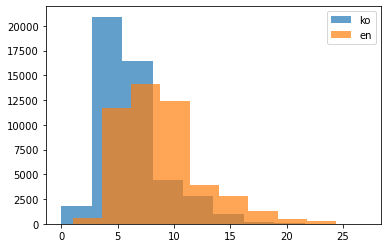

In [47]:
import matplotlib.pyplot as plt

len_ko = []
for data in encoder_input:
    len_ko.append(len(data))

len_en = []
for data in decoder_input:
    len_en.append(len(data))

plt.hist(len_ko, label='ko', alpha=0.7)
plt.hist(len_en, label='en', alpha=0.7)
plt.legend()
plt.show()

In [48]:
# maxlen 없어도 알아서 잘 패딩합니다
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

In [49]:
print(encoder_input.shape)
print(decoder_input.shape)

(47667, 27)
(47667, 27)


In [50]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[10325  1216   312 23138     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [10325    66  8026  6543    12     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [ 8027 23139 23140  1162 23141     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]
[[    2     1   175    97   670    19     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    2     1   761    78    31  2133 11983     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    2  1324  6699     1  2852     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      

In [51]:
# 나중에 prediction 할때 사용하기 위함 (인덱스로 단어 찾기)
en_to_index = tokenizer_en.word_index
index_to_en = tokenizer_en.index_word

In [52]:
# 3:1로 나눴습니다
test_size = 12000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

# Training

In [53]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [54]:
# 인코더 모델 - 한글 문장 받아서 LSTM 마지막 시점의 은닉/셀 상태 리턴하도록
# 훈련할때는 47667(전체데이터)-12000(테스트)=35667(훈련)
# input -> 35667 x 27 (훈련할때는)
# input -> 12000 x 27 (테스트할때는)
encoder_inputs = Input(shape=(27,)) # 27은 한글 문장의 길이
# +1해서 패딩까지
encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_inputs)
# 패딩(0)에 해당하는 임베딩 벡터는 제외
encoder_mask = Masking(mask_value=0)(encoder_embed)
# return state -> 마지막 은닉, 마지막 은닉, 마지막 셀 총 3개 리턴 (오타 아닙니다)
# lstm 셀 자체의 한 시점의 출력은 은닉 상태값 -> softmax 함수를 통과하면서 y값
# encoder_outputs는 마지막 은닉 상태 값, h_state도 마지막 은닉 상태 값
# encoder_outputs == h_state
encoder_outputs, h_state, c_state = LSTM(50, return_state=True)(encoder_mask)

In [55]:
# 디코더 모델 - 인코더의 상태값(h,c)이랑, 영어 문장을 입력받아서 LSTM의 출력값(은닉 상태), 이걸 받아서 softmax 함수를 통과시키도록
decoder_inputs = Input(shape=(27,)) #27은 영어 문장의 길이
decoder_embed = Embedding(len(tokenizer_en.word_index)+1, 50)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)
# return sequences 쓰면 전체 시점의 은닉 상태 값 (각 단어 인풋 별 은닉 상태 값) 을 리턴
# 둘 다 쓰게되면 전체 시점의 은닉 상태, 마지막 은닉 상태, 마지막 셀 상태
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
# decoder_outputs는 전체 시점의 은닉 상태 값
# decoder는 마지막 시점의 은닉/셀 상태 값이 중요하지 않기 때문에 _
# 위에서 받은 h_state, c_state 값을 초기 상태값으로
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state])
# 패딩을 한 후에 지금 0~단어갯수 -> 수를 가진 decoder_input/output
# [0 1 2 3 4 5 6 7 8 9 10 11 ~~~ 단어갯수] -> 어레이
# [0번째 인덱스의 단어가 다음단어일 확률 / 1번째 인덱스의 단어가 다음단어일 확률 / 0.2 / 0.3 ... ~ 단어갯수] (지금 input으로 들어간 단어의 다음 단어일 확률값)
decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax')
decoder_softmax_outputs = decoder_dense(decoder_outputs)

In [56]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# sparse는 라벨이 정수 형태로 제공될 때 사용되는 함수 (그냥 categorical은 원핫 벡터로 라벨이 제공될 때)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
# 레이어 별로 가중치가 학습되는 것임
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_output_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), batch_size = 128, epochs = 50)

Train on 35667 samples, validate on 12000 samples
Epoch 1/50
18048/35667 [==============>...............] - ETA: 8:39 - loss: 4.6768 - acc: 0.6759

KeyboardInterrupt: 

# Prediction

In [37]:
# 인코더가 출력하는 마지막 시점의 셀/은닉 상태 값 따로 구하고
# <start> 라는 인풋을 따로 디코더 모델의 lstm에 집어넣어서
# lstm에서 내는 아웃풋 다시 lstm에 계속 집어넣는 형태로
# 그러다가 <end>가 보이면 그만

In [38]:
# 인코더가 출력하는 마지막 시점의 셀/은닉 상태 값 따로 구하고
# h_state, c_state는 아웃풋 레이어 (LSTM) 를 명시한 것
# encoder_inputs는 encoder_input과 다릅니다
# 훈련을 하고 나면 레이어 별로 가중치를 학습, 훈련이 되었으니 학습된 가중치를 가진 레이어를 그대로 
encoder_model = Model(encoder_inputs, [h_state, c_state])

In [39]:
# 디코더 모델을 만들건데, 디코더 모델에 초기값으로 넣을 상태값의 모양을 지정
encoder_h_state = Input(shape=(50,))
encoder_c_state = Input(shape=(50,))

# 우리가 시퀀스를 넣을게 아니라, 단어단어를 넣을거기 때문에
# 시점이 여러개가 아니라, 한 시점만 존재
# 상태값을 자동으로 넘겨주지 않기 때문에, 직접 넘겨줘야한다
# 셀 마다마다 상태의 초기값을 지정 / 나오는 상태값을 저장
pd_decoder_outputs, pd_h_state, pd_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_h_state, encoder_c_state])
pd_decoder_softmax_outputs = decoder_dense(pd_decoder_outputs)

# 모델은 디코더 인풋 (<start>), 인코더의 상태값이 인풋으로 들어간다
# lstm 셀 통과하면서 예측, softmax 함수를 통과한 출력값 (각 단어별 다음 단어일 확률값), 디코더의 상태값 두 개를 출력하는 것
# softmax 함수를 통과한 출력값 (확률) 을 토대로 다음 단어를 확정
# 다시 그 단어를 디코더 인풋으로 + 전 시점의 디코더의 상태값이 인풋으로 들어간다
decoder_model = Model([decoder_inputs] + [encoder_h_state, encoder_c_state], [pd_decoder_softmax_outputs] + [pd_h_state, pd_c_state])

In [40]:
input_stc = input()
token_stc = input_stc.split()
encode_stc = tokenizer_ko.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=27, padding="post")

# 인코더의 마지막 시점의 셀/은닉 상태 값
states_value = encoder_model.predict(pad_stc)

# <start> 를 정수 인코딩해서 numpy array 로
predicted_seq = np.zeros((1,1))
predicted_seq[0, 0] = en_to_index['<start>']

# 각 시점마다 예측된 단어를 저장
decoded_stc = []

while True:
    output_words, h, c = decoder_model.predict([predicted_seq] + states_value)

    predicted_word = index_to_en[np.argmax(output_words[0,0])]  

    if predicted_word == '<end>':
        break

    decoded_stc.append(predicted_word)

    # 처음에는 <start>, 지금은 예측된 단어가 있으니 이것을 인풋으로 넣어주기 위해서 변수의 값을 업데이트
    predicted_seq = np.zeros((1,1))
    predicted_seq[0, 0] = np.argmax(output_words[0,0])

    # 지금 시점의 상태 값을 다음 시점으로 넘기기 위해서 변수를 업데이트
    states_value = [h, c]

print(' '.join(decoded_stc))

KeyError: '<start>'